# Predicting FFRs using a neural network

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

plt.rcParams['figure.figsize'] = [8, 4]

Using cpu device


In [12]:
df = pd.read_csv("FFR_data.csv")
df.dropna(inplace=True)

In [13]:
X = df.drop(columns=["FFR"])
y = df[["FFR"]]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.Tensor(X).to(device)
y = torch.Tensor(y.values).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y)

batch_size = 12
train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

Note: Due to the relatively small size of the dataset, model performance may differ depending on the random state of `train_test_split()`.

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(6, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.stack(x)
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)


In [15]:
@torch.no_grad()
def accuracy_score(y, y_pred):
    y = y.flatten()
    y_pred = y_pred.flatten()
    y_pred_labels = torch.round(torch.sigmoid(y_pred))
    ans = (y == y_pred_labels).sum() / y.shape[0]
    return float(ans.detach().cpu())

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

# Record some data during training
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1000):
    for batch, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        train_loss = float(loss.detach().cpu())
        train_losses.append(train_loss)

        with torch.no_grad():
            output = model(X_test)
            loss = criterion(output, y_test)
            test_loss = float(loss.detach().cpu())
            test_losses.append(test_loss)

            test_accuracy = accuracy_score(y_test, output)
            test_accuracies.append(test_accuracy)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch:04}, Train loss: {train_loss:.5f}, Test loss: {test_loss:.5f}, Test accuracy: {test_accuracy:.5f}"
        )

Epoch: 0000, Train loss: 0.71485, Test loss: 0.61415, Test accuracy: 0.75000
Epoch: 0100, Train loss: 0.16466, Test loss: 0.39080, Test accuracy: 0.83333
Epoch: 0200, Train loss: 0.06319, Test loss: 0.21742, Test accuracy: 0.91667
Epoch: 0300, Train loss: 0.02578, Test loss: 0.23279, Test accuracy: 0.91667
Epoch: 0400, Train loss: 0.01376, Test loss: 0.27143, Test accuracy: 0.91667
Epoch: 0500, Train loss: 0.00866, Test loss: 0.30465, Test accuracy: 0.91667
Epoch: 0600, Train loss: 0.00604, Test loss: 0.33243, Test accuracy: 0.91667
Epoch: 0700, Train loss: 0.00448, Test loss: 0.35617, Test accuracy: 0.91667
Epoch: 0800, Train loss: 0.00347, Test loss: 0.37698, Test accuracy: 0.91667
Epoch: 0900, Train loss: 0.00277, Test loss: 0.39564, Test accuracy: 0.91667


In [17]:
def plot_training_data(train_losses, test_losses, test_accuracies):
    fig, ax1 = plt.subplots()
    ax1.set_title("Training data")

    color = "tab:blue"
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Loss", color=color)
    ax1.tick_params(axis="y", labelcolor=color)
    batches = list(range(len(train_losses)))

    ax1.plot(batches, train_losses, label="train loss", color=color)
    ax1.plot(batches, test_losses, label="test loss", linestyle="dashed", color=color)

    color = "tab:green"
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color=color)
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.plot(batches, test_accuracies, label="test accuracy", color=color)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="right")

    fig.tight_layout()

Final test accuracy: 0.9166666865348816


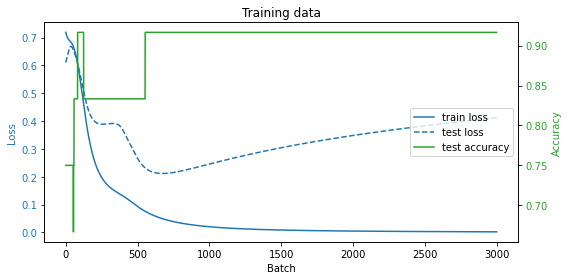

In [18]:
print(f"Final test accuracy: {test_accuracies[-1]}")
plot_training_data(train_losses, test_losses, test_accuracies)